# 机器学习进阶毕业项目—驾驶员状态检测—Xception—fine tune

### 一、数据预处理

#### 1、根据司机ID划分训练集和验证集，将P016,P035, P066两位司机，共2315个数据作为验证集，其余25位司机，共20109个数据作为训练集。将验证集从原始文件里移动到验证集相应的分类文件里。

In [1]:
import os
import pandas as pd
import numpy as np
import shutil

valid_subjects = ['p016','p035','P066']

if not os.path.exists("Xception/valid"):
    os.mkdir("Xception/valid")
    for i in range(10):
        os.mkdir("Xception/valid/c%d"%i)

df = pd.read_csv(os.path.join('input', "driver_imgs_list.csv"))

for valid_subject in valid_subjects:
    df_valid = df[(df["subject"]==valid_subject)]
    for index, row in df_valid.iterrows():
        subpath = row["classname"] + "/" + row["img"]
        if os.path.exists(os.path.join('Xception',"train",subpath)):
            shutil.move(os.path.join('Xception',"train",subpath), os.path.join('Xception',"valid",subpath),)
        else:
            print("cannot move {} : {}".format(row["subject"],subpath))

### 二、加载数据集

In [37]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
np.random.seed(2018)
batch_size=64

gen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
)

#gen_test = ImageDataGenerator()

train_generator = gen_train.flow_from_directory(os.path.join('Xception','train'), target_size=(299,299), shuffle=True, batch_size=batch_size,class_mode="categorical")
valid_generator = gen_train.flow_from_directory(os.path.join('Xception','valid'), target_size=(299,299), shuffle=True, batch_size=batch_size,class_mode="categorical")
#test_generator = gen_test.flow_from_directory(os.path.join('input', 'test'), target_size=(299,299), shuffle=True, batch_size=batch_size, class_mode=None)

Found 20498 images belonging to 10 classes.
Found 1926 images belonging to 10 classes.


### 三、构建模型

In [38]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
np.random.seed(2018)

image_size=(299,299)
input_tensor = Input((*image_size, 3))
x = input_tensor
x = Lambda(xception.preprocess_input)(x)

base_model = Xception(input_tensor = x, weights='imagenet',include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.5)(x)
predictions = Dense(10,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

In [39]:
def fine_tune_a(model,base_model):
    fine_tune_layer_a = 81 
    for layer in base_model.layers[:fine_tune_layer_a-1]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_layer_a:]:
        layer.trainable = True
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
def fine_tune_b(model,base_model):
    fine_tune_layer_b = 81 
    for layer in base_model.layers[:fine_tune_layer_b-11]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_layer_b:]:
        layer.trainable = True
    model.compile(optimizer=RMSprop(lr=2e-5),loss='categorical_crossentropy',metrics=['accuracy'])

### 四、训练模型

#### 1、训练结果可视化，查看模型训练过程中的acc+loss+val_acc+val_loss

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

#### 2、fine_tune_a，从106层进行fine_tune.

Epoch 1/1
321/321 [==============================] - 732s 2s/step - loss: 0.1737 - acc: 0.9457 - val_loss: 0.2982 - val_acc: 0.8951


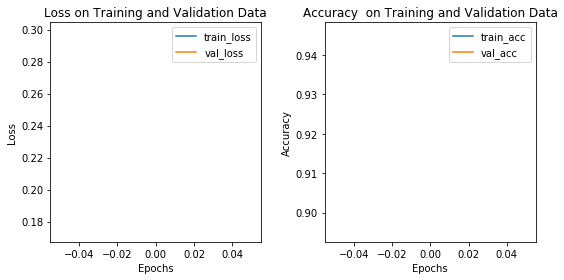

In [41]:
fine_tune_a(model,base_model)
hist2 = model.fit_generator(generator=train_generator,epochs=1,validation_data=valid_generator)
training_vis(hist2)

In [42]:
model.save("weights/Xception-finetune_81.h5")
print("model saved")

model saved


#### 4、fine_tune_b，调小学习率，进一步进行fine_tune.

In [43]:
fine_tune_b(model,base_model)
model.fit_generator(generator=train_generator,epochs=1,validation_data=valid_generator)

Epoch 1/1
321/321 [==============================] - 730s 2s/step - loss: 0.0217 - acc: 0.9943 - val_loss: 0.4330 - val_acc: 0.8551


In [27]:
model.save("weights/Xception-finetune_76.h5")
print("model saved")

model saved


In [36]:
model.compile(optimizer=Adagrad(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit_generator(generator=train_generator,epochs=1,validation_data=valid_generator)

Epoch 1/1
321/321 [==============================] - 749s 2s/step - loss: 0.0115 - acc: 0.9969 - val_loss: 0.3629 - val_acc: 0.9029


### 六、预测测试集

#### 1、创建提交文件格式。

In [44]:
import datetime
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

#### 2、获取测试集ID

In [45]:
import glob
def get_test_id():
    X_test_id = []
    print('get test ID')

    path = os.path.join( 'input', 'test', 'test','*.jpg')
    files = sorted(glob.glob(path))
    for fl in files:
        flbase = os.path.basename(fl)
        X_test_id.append(flbase)

    return X_test_id

#### 3、预测测试集并保存预测结果。

In [51]:
from keras.models import load_model
import pandas as pd
import numpy as np
model.load_weights('weights/Xception-finetune_81.h5')

In [52]:
gen_test = ImageDataGenerator()
test_generator = gen_test.flow_from_directory(os.path.join('input', 'test'), target_size=(299,299), shuffle=False, batch_size=16, class_mode=None)

y_pred = model.predict_generator(test_generator,verbose=1)
#y_pred = y_pred.clip(min=0.005, max=0.995)


Found 79726 images belonging to 1 classes.
4983/4983 [==============================] - 1966s 395ms/step


In [53]:
test_id=get_test_id()
info_string = 'loss'+ '_Xception'
        
create_submission(y_pred, test_id, info_string)
print("submission done")

get test ID
submission done
